# Setup

In [1]:
import getpass
import numpy as np
import matplotlib.pyplot as plt

import axs
import pyspark.sql.functions as sparkfunc

import dipper

In [2]:
%matplotlib notebook

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[20]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
    )   

    return spark

username = getpass.getuser()
spark_session = spark_start(f"/epyc/users/{username}/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

# Load the catalog with the best dippers

In [453]:
zz = catalog.load('wtf_selection_0423_10000').select('*').toPandas().sort_values('dip_significance', ascending=False)

/epyc/opt/anaconda/lib/python3.7/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [454]:
%matplotlib inline

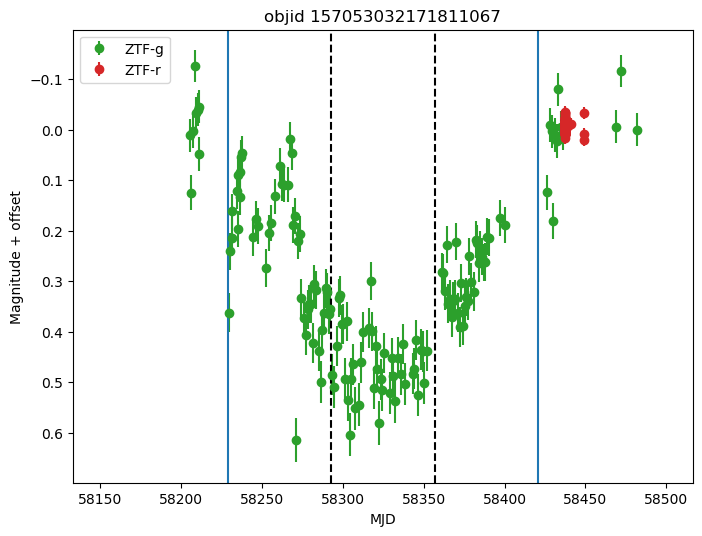

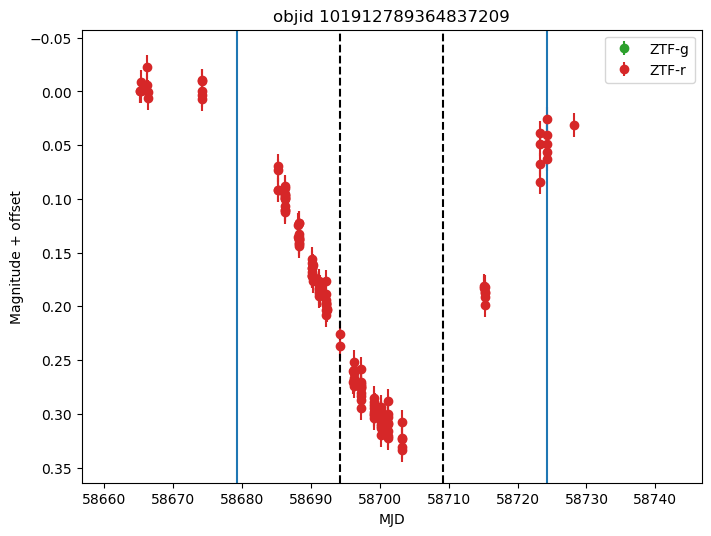

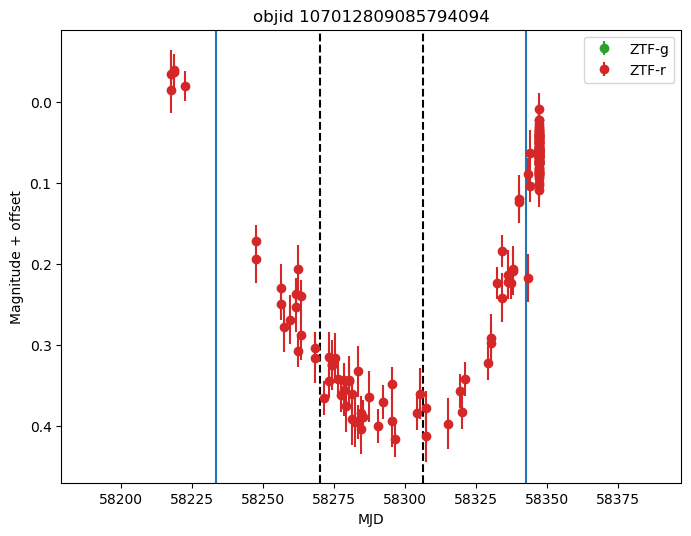

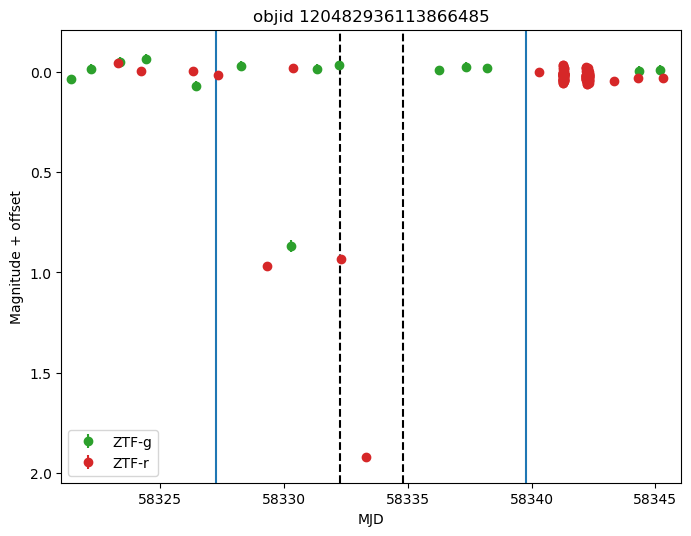

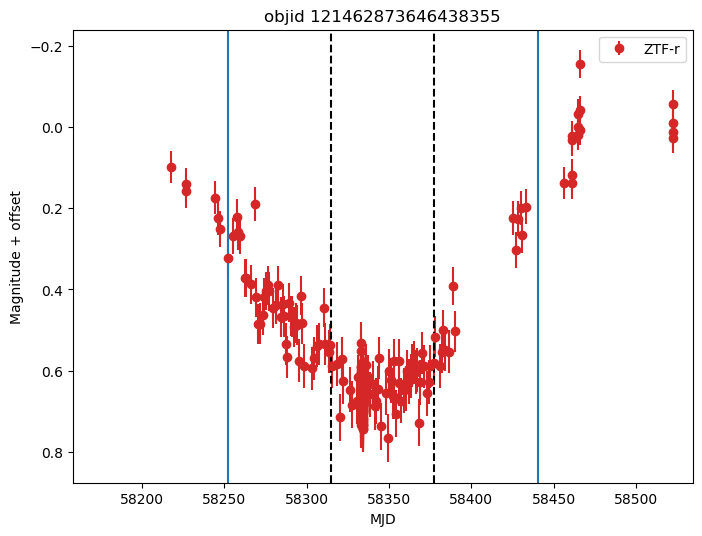

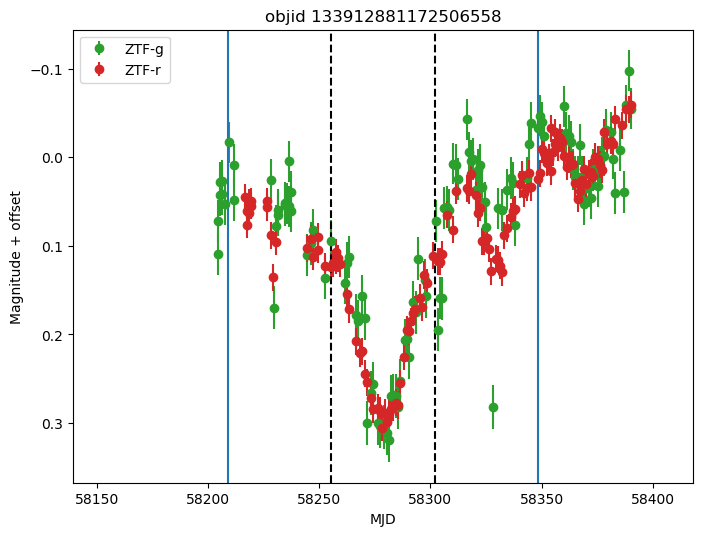

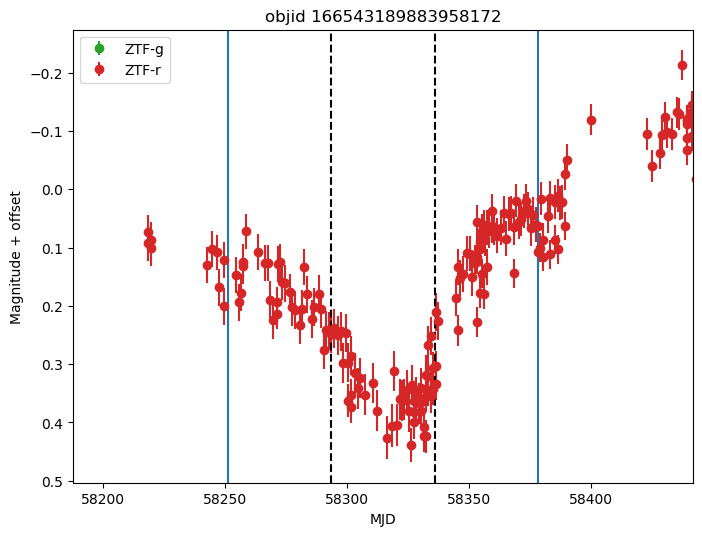

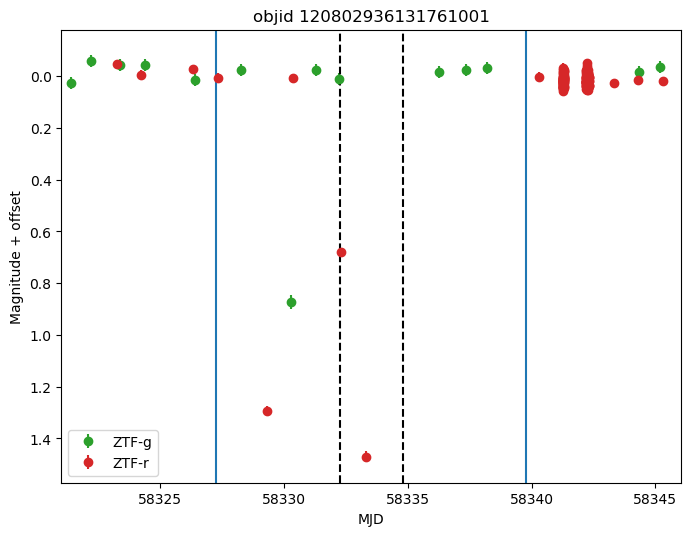

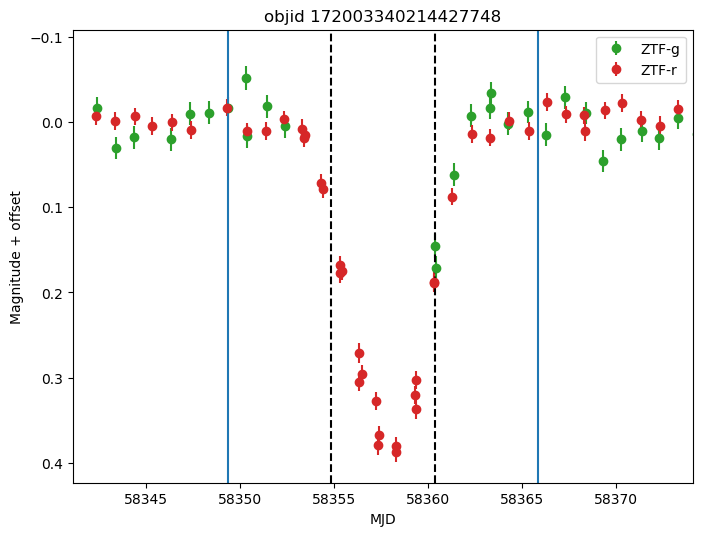

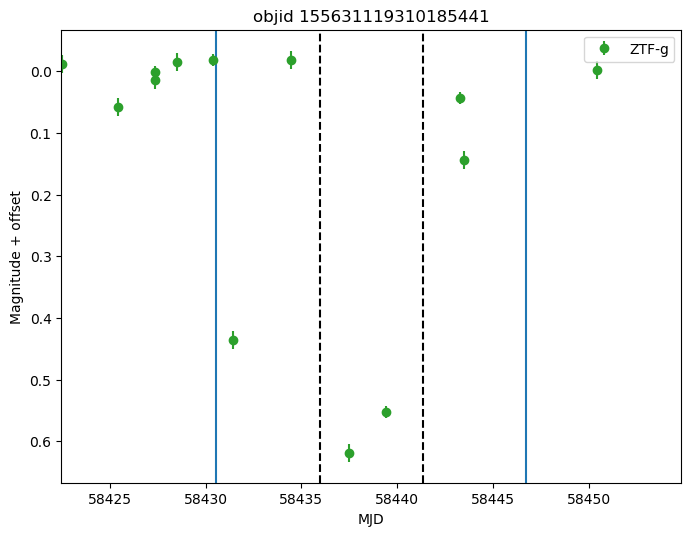

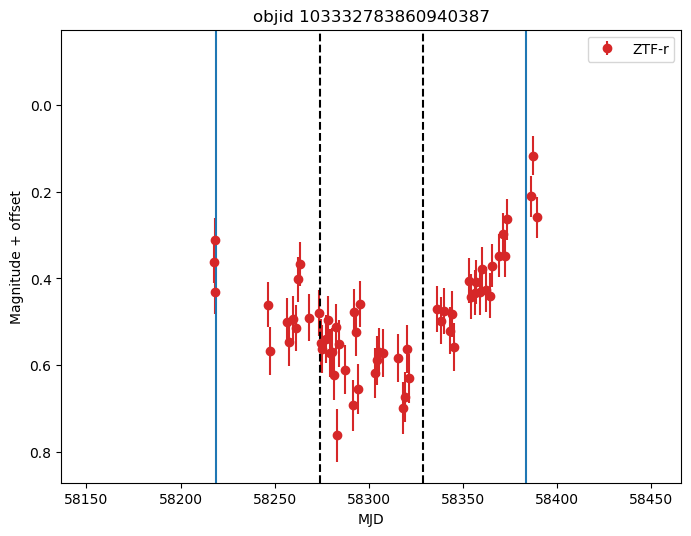

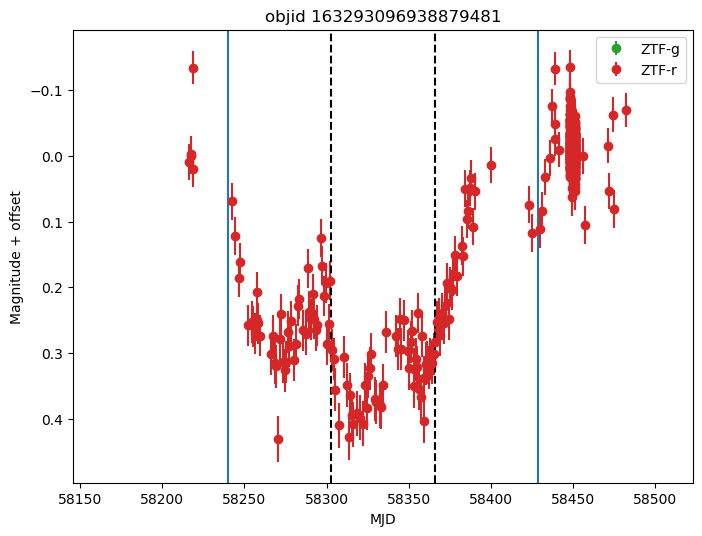

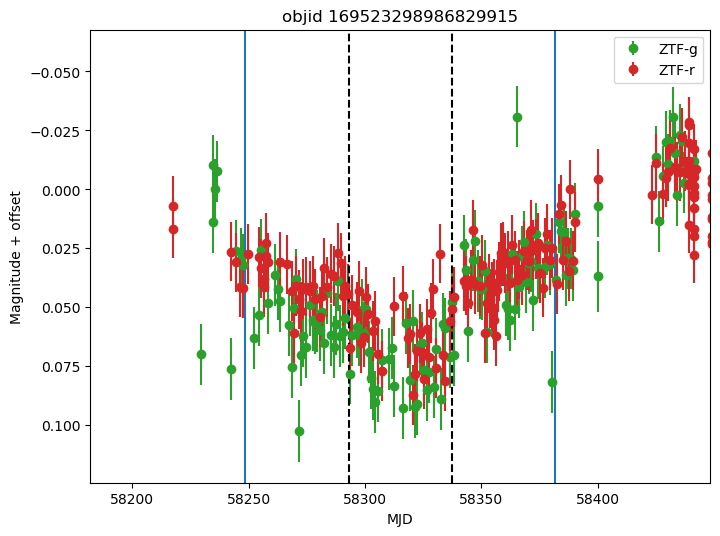

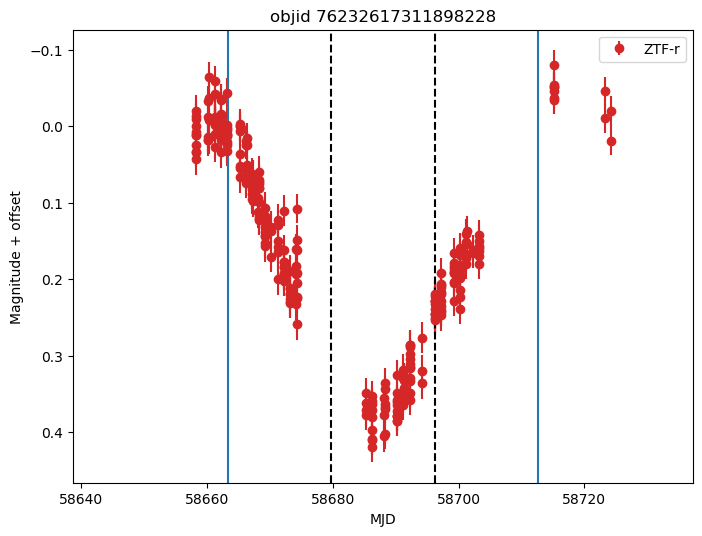

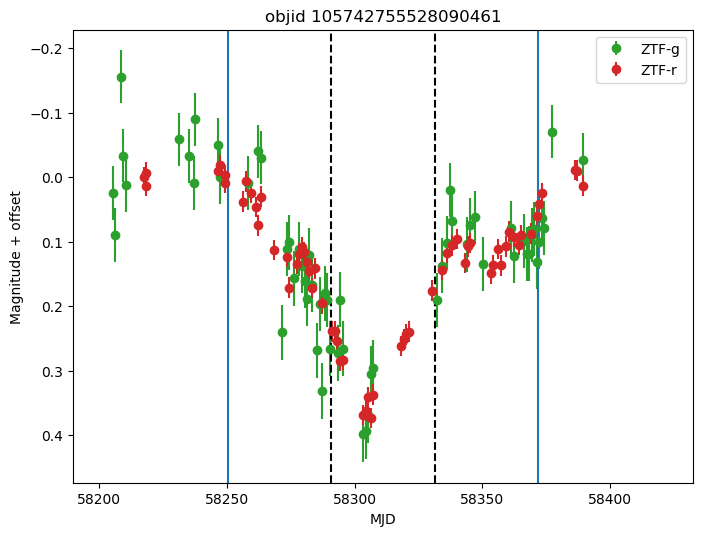

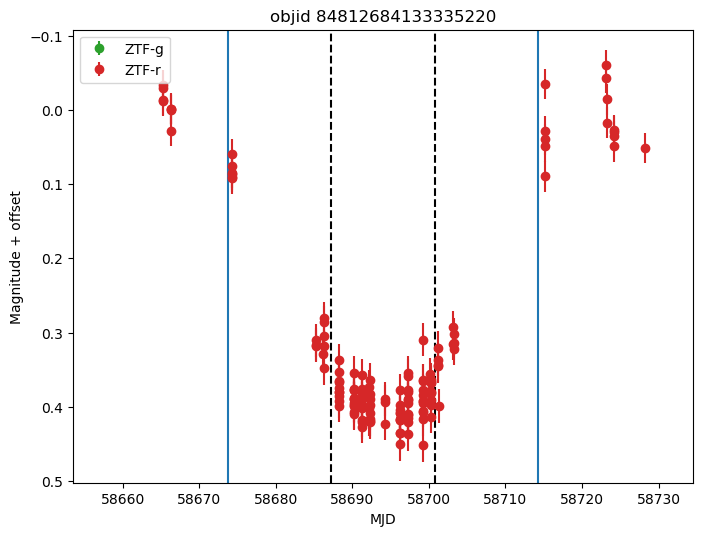

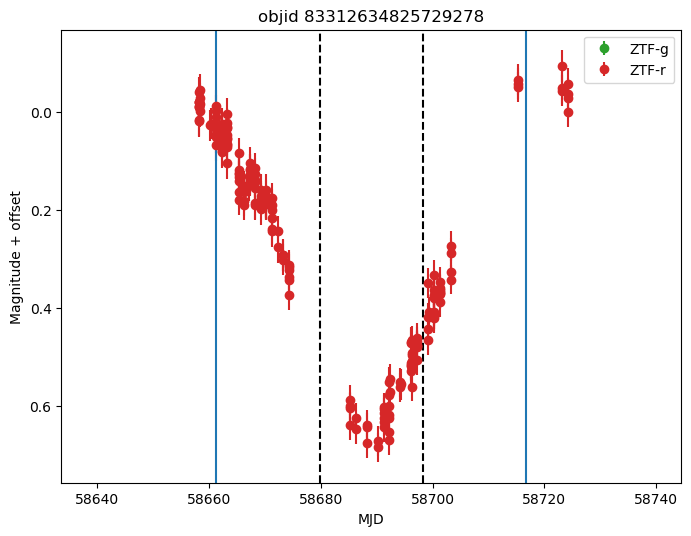

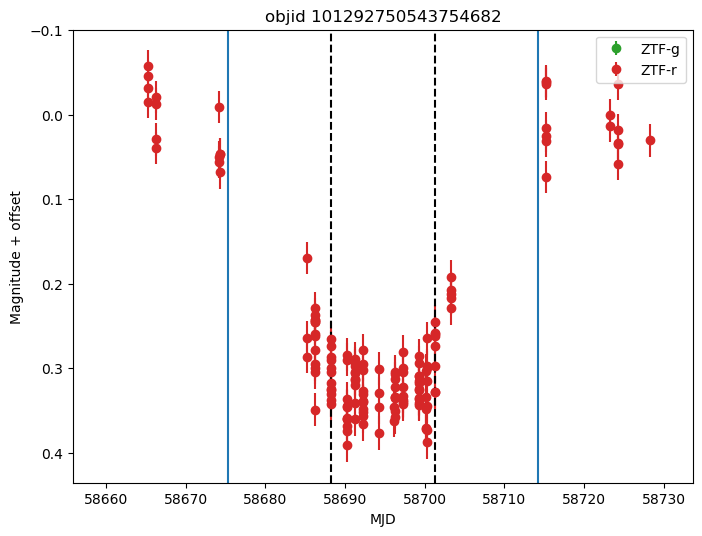

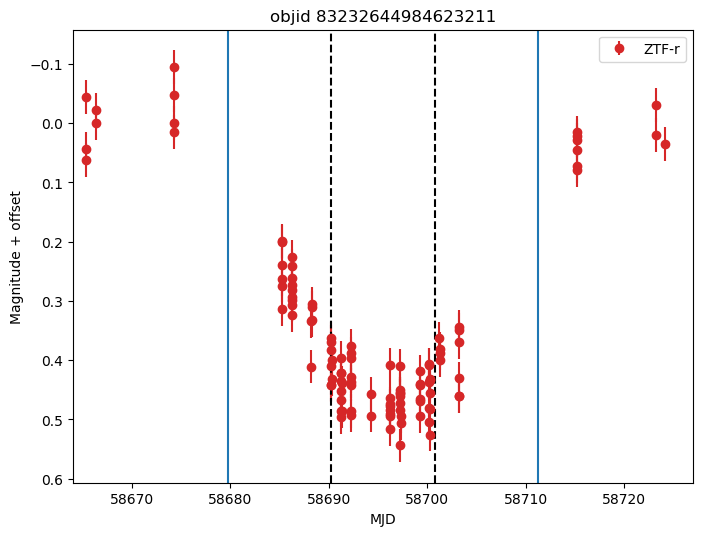

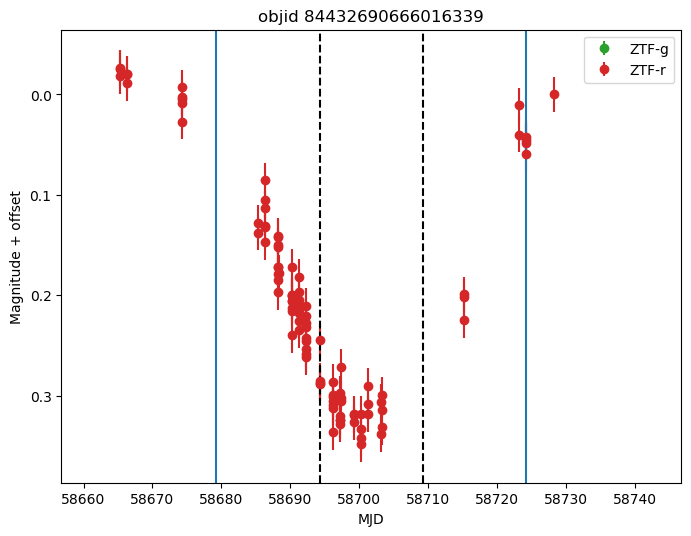

In [457]:
for idx in range(0, 20):
    dipper.plot_light_curve(zz.iloc[idx], parsed=True, verbose=False, zoom=True, label_dip=True)

# Rerun the dipper algorithm

In [458]:
# Load a catalog where we have used loose selection cuts
# to find dippers. This has 4.5M lightcurves
wtf = catalog.load('wtf_integral_full_2')

In [242]:
# Recalculate the dipper scores. Note, Spark uses lazy evaluation, so
# this doesn't actually do anything until we do something with
# the results.
rescored_wtf = (
    wtf
    .drop('dip')
    .select(
        '*',
        dipper.build_measure_dip_udf()(
            wtf['mjd_g'],
            wtf['mag_g'],
            wtf['magerr_g'],
            wtf['xpos_g'],
            wtf['ypos_g'],
            wtf['catflags_g'],
            wtf['mjd_r'],
            wtf['mag_r'],
            wtf['magerr_r'],
            wtf['xpos_r'],
            wtf['ypos_r'],
            wtf['catflags_r'],
            wtf['mjd_i'],
            wtf['mag_i'],
            wtf['magerr_i'],
            wtf['xpos_i'],
            wtf['ypos_i'],
            wtf['catflags_i'],
        ).alias('dip'),
    )
    .where(
        #(sparkfunc.col("dip.significant_observation_count") >= 3)
        # & (sparkfunc.col("dip.core_not_significant_fraction") <= 0.2)
        #& (sparkfunc.col("dip.significant_width") >= 0.5)
        (sparkfunc.col("dip.significance") >= 5)
        #& (sparkfunc.col("dip.ref_pull_std") < 1.5)
        #& (sparkfunc.col("dip.ref_large_pull_fraction") < 0.1)
        #& (sparkfunc.col("dip.max_gap_fraction") < 0.8)
        & (sparkfunc.col("dip.deep_gap_fraction") < 0.8)
        & (sparkfunc.col("dip.deep_count") > 3.)
        & (sparkfunc.col("dip.ref_pull_std") < 2.)
        & (sparkfunc.col("dip.significant_length") >= 0.5)
        & (sparkfunc.col("dip.flip_count") <= 4)
    )
)
rescored_wtf.write.mode('overwrite').parquet('./extracted_lightcurves.parquet')

## Build an AXS table with the top light curves

In [445]:
parquet_wtf = spark_session.read.parquet('./extracted_lightcurves.parquet')

def save_axs_table(count):
    cut_table = parquet_wtf.sort(parquet_wtf['dip.significance'].desc()).limit(count)
    
    # Pull all of the dip keywords out so that pandas can access them.
    select = ['*']
    for key in cut_table.schema['dip'].dataType.fieldNames():
        select.append(cut_table['dip'][key].alias(f'dip_{key}'))
        
    cut_table = cut_table.select(*select)
    cut_table = cut_table.drop('dip')

    catalog.save_axs_table(cut_table, f'wtf_selection_0423_{count}', repartition=True)

save_axs_table(10000)